In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd


In [2]:
# pydf = df.sort_values('id')
# pydf['PY'] = pys
# df = pydf.sort_index()
# df.to_csv('../data/1_predicted_category_documents.csv',index=False)
# #df[['id','content','PY']].head()

In [3]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')
cat_df = pd.read_csv('../data/1_predicted_category_documents.csv')
predictions = pd.read_csv('../data/1_document_relevance.csv')
df = cat_df.merge(cat_df.merge(predictions), how="outer")

# Merge actual and predicted categories
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]
for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())
print(pred_cats)

pred_cats = [
    "12 - Terrestrial ES - mean_prediction",
    "12 - Coastal and marine Ecosystems - mean_prediction",
    "12 - Mountains, snow and ice - mean_prediction",
    "12 - Rivers, lakes, and soil moisture - mean_prediction",
    "12 - Human and managed - mean_prediction",
    #"12 - Total"
]

# Merge actual and predicted specific categories

extra_cat_df = pd.read_csv('../data/1_predicted_category_documents_specific.csv')

specific_impact_cats = [x for x in extra_cat_df.columns if "18 -" in x and "mean" in x]

extra_cat_df = extra_cat_df[["id"]+[x for x in extra_cat_df.columns if "18 - " in x] ]

df = df.merge(extra_cat_df, how="outer")

print(df.shape)

import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../literature_identification/jupyter-google-e4b72bf44320.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1o18FIQTmGSWJ_m1ePAzrcVhFlfesESCb2bIEG7ibJAA'
wb = gc.open_by_key(spreadsheet_key)
ws = wb.worksheet("category_label_numbers")
table = ws.get_all_values()
category_map = pd.DataFrame(table[1:], columns=table[0])

impact_columns = [x for x in df.columns if re.match("^4 - ",x)]
for x in impact_columns:
    row = category_map.loc[category_map['Specific category']==x.split(' - ')[1]]
    if row.shape[0]==0:
        continue
    for i, aggscheme in enumerate(row[['Proposed Aggregation 1', 'Proposed Aggregation 2']].values[0]):
        if aggscheme not in ['-','']:
            nc = f'{17+i} - {aggscheme}'
            if nc not in df.columns:
                df[nc] = 0
            df.loc[df[x]==1,nc] = 1

specific_impacts = [
    '18 - Terrestrial Water Cycle - mean_prediction',
    '18 - Drought & Floods - mean_prediction',
    '18 - Cryosphere - mean_prediction',
    '18 - Coastal and marine Ecosystems - mean_prediction',
    '18 - Terrestrial ES - mean_prediction',
    #'18 - Carbon Cycle - mean_prediction',
    '18 - Wildfires - mean_prediction',
    '18 - Food/Agriculture - mean_prediction',
    '18 - Livelihoods and wellbeing - mean_prediction',
    '18 - Health - mean_prediction',
    '18 - Displacement and migration - mean_prediction',
    #'18 - Other anthropogenic - mean_prediction'
]

for c in specific_impacts:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())
    
attrib_cats = [c for c  in df.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    #df.loc[df[label]==1,c] = 1
    print(df[c].sum())

# Merge actual and predicted relevance
pcols = [
    '0 - relevance - mean_prediction',
    '0 - relevance - lower_pred',
    '0 - relevance - upper_pred'
]

df.loc[df['relevant']==1,pcols]=1

df.head()

12291.1
12464.1
10176.9
10457.9
4585.8
4744.8
11683.5
11976.5
29838.399999999998
30281.399999999998
['12 - Coastal and marine Ecosystems - mean_prediction', '12 - Human and managed - mean_prediction', '12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Terrestrial ES - mean_prediction']
(97122, 284)
10537.036681432624
10683.036681432624
6160.793234897791
6222.793234897791
4449.103043613481
4522.103043613481
8148.634285719894
8217.634285719894
27910.94760679921
28185.94760679921
1312.8691462897752
1342.8691462897752
3198.492303500201
3251.492303500201
3619.816621039322
3668.5669752009553
4381.209047054287
4506.209047054287
1201.1529353857718
1232.2761132378346
42086.4
42534.4
34201.2
34539.2
4375.8
4472.8


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,17 - Ecosystem productivity and carbon cycle (CMES),17 - Distribution and range shifts (TES),17 - Phenology (TES),"17 - Physiology, metabolism, mortality and growth (TES)",17 - Community composition and interaction (TES),17 - Ecosystem productivity and carbon cycle (TES),17 - Wildfires,17 - Livelihoods and wellbeing,17 - Health,17 - Displacement and migration
0,0,1298506,"In this study, we evaluated the effects of CO2...",Effects of seawater acidification on the early...,seawater acidification; Glyptocidaris crenular...,['Limnology; Oceanography'],NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1294278,"Mean air temperatures and the frequency, inten...",Nest box design for a changing climate: The va...,artificial hollows; climate change; hollow-nes...,['Ecology'],NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1522976,Surging glaciers are potential analogues for l...,Glacial geological studies of surge-type glaci...,Surge-type glacier; Iceland; Landsystem model;...,"['Geosciences, Multidisciplinary']",NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,11008,Deposits of the Last Interglacial on the south...,THE LAST INTERGLACIAL IN THE MEDITERRANEAN AS ...,NaN,"['Geography, Physical; Geosciences, Multidisci...",NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,772888,Identifying patterns in the effects of tempera...,Cross-taxa generalities in the relationship be...,climate change; population size; time series; ...,['Biology; Ecology; Evolutionary Biology'],NaN,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
places = pd.read_csv('../data/place_df.csv')
places.head()

,word,spans,country_predicted,country_conf,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code
0,Barents Sea,"[{'start': 329, 'end': 340}]",NaN,0.904877,1340101,NaN,74.00000,36.00000,NaN,630674.0,Barents Sea,H,SEA
1,East Siberia,"[{'start': 1228, 'end': 1240}]",NaN,0.904877,1340101,NaN,74.00000,166.00000,NaN,2127381.0,East Siberian Sea,H,SEA
2,Gulf Coast,"[{'start': 497, 'end': 507}]",USA,0.904877,222401,Mississippi,29.36901,-95.00565,USA,7287689.0,Gulf Coast,L,AREA
3,San Diego,"[{'start': 114, 'end': 123}]",USA,0.963741,3307272,California,33.02820,-116.77021,USA,5391832.0,San Diego County,A,ADM2
4,Alaska,"[{'start': 91, 'end': 97}]",USA,0.959621,355004,Alaska,64.00028,-150.00028,USA,5879092.0,Alaska,A,ADM1


In [5]:
import pycountry_convert as pc
def get_cont(x):
    continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Oceania',
        'AF': 'Africa',
        'EU': 'Europe'
    }
    try:
        return continents[pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))]
    except:
        return None
places['continent'] = places.apply(lambda x: get_cont(x), axis=1)
other_country_continents = [
    ("ESH","Africa"),
    ("TLS","Oceania"),
    ("XKX","Europe")
    
]
for country,continent in other_country_continents:
    places.loc[places['country_predicted']==country,"continent"] = continent

places.head()


,word,spans,country_predicted,country_conf,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,continent
0,Barents Sea,"[{'start': 329, 'end': 340}]",NaN,0.904877,1340101,NaN,74.00000,36.00000,NaN,630674.0,Barents Sea,H,SEA,None
1,East Siberia,"[{'start': 1228, 'end': 1240}]",NaN,0.904877,1340101,NaN,74.00000,166.00000,NaN,2127381.0,East Siberian Sea,H,SEA,None
2,Gulf Coast,"[{'start': 497, 'end': 507}]",USA,0.904877,222401,Mississippi,29.36901,-95.00565,USA,7287689.0,Gulf Coast,L,AREA,North America
3,San Diego,"[{'start': 114, 'end': 123}]",USA,0.963741,3307272,California,33.02820,-116.77021,USA,5391832.0,San Diego County,A,ADM2,North America
4,Alaska,"[{'start': 91, 'end': 97}]",USA,0.959621,355004,Alaska,64.00028,-150.00028,USA,5879092.0,Alaska,A,ADM1,North America


In [6]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,continent
0,0,1298506,"In this study, we evaluated the effects of CO2...",Effects of seawater acidification on the early...,seawater acidification; Glyptocidaris crenular...,['Limnology; Oceanography'],NaN,0.0,0.0,0,...,1298506,Hubei,30.52047,114.39637,CHN,6620465.0,China University of Geosciences,S,SCHC,Asia
1,0,1298506,"In this study, we evaluated the effects of CO2...",Effects of seawater acidification on the early...,seawater acidification; Glyptocidaris crenular...,['Limnology; Oceanography'],NaN,0.0,0.0,0,...,1298506,British Columbia,49.14399,-122.90680,CAN,5937615.0,Delta,P,PPL,North America
2,2,1522976,Surging glaciers are potential analogues for l...,Glacial geological studies of surge-type glaci...,Surge-type glacier; Iceland; Landsystem model;...,"['Geosciences, Multidisciplinary']",NaN,0.0,0.0,0,...,1522976,NaN,65.00000,-18.00000,ISL,2629691.0,Republic of Iceland,A,PCLI,Europe
3,3,11008,Deposits of the Last Interglacial on the south...,THE LAST INTERGLACIAL IN THE MEDITERRANEAN AS ...,NaN,"['Geography, Physical; Geosciences, Multidisci...",NaN,0.0,0.0,0,...,11008,NaN,40.00000,-4.00000,ESP,2510769.0,Kingdom of Spain,A,PCLI,Europe
4,3,11008,Deposits of the Last Interglacial on the south...,THE LAST INTERGLACIAL IN THE MEDITERRANEAN AS ...,NaN,"['Geography, Physical; Geosciences, Multidisci...",NaN,0.0,0.0,0,...,11008,Louisiana,29.51353,-91.83964,USA,4328254.0,Iberia Parish,A,ADM2,North America


In [7]:
places[pd.isna(places['country_predicted'])].head()

,word,spans,country_predicted,country_conf,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,continent
0,Barents Sea,"[{'start': 329, 'end': 340}]",NaN,0.904877,1340101,NaN,74.0,36.00,NaN,630674.0,Barents Sea,H,SEA,None
1,East Siberia,"[{'start': 1228, 'end': 1240}]",NaN,0.904877,1340101,NaN,74.0,166.00,NaN,2127381.0,East Siberian Sea,H,SEA,None
19,Japan Sea,"[{'start': 847, 'end': 856}]",NaN,0.821268,192498,NaN,43.5,135.75,NaN,2038684.0,Sea of Japan,H,SEA,None
23,North Pacific Ocean,"[{'start': 63, 'end': 82}]",NaN,0.852964,792016,NaN,30.0,-170.00,NaN,4030875.0,North Pacific Ocean,H,OCN,None
36,Earth,"[{'start': 437, 'end': 442}]",NaN,0.777676,711757,NaN,0.0,0.00,NaN,6295630.0,Earth,L,AREA,None


In [8]:
places[places['feature_code']=="CONT"].shape

(1345, 14)

In [9]:
# Docs with no places
df[~df['id'].isin(df_places['doc_id'])].shape[0] / df.shape[0]



0.2908197936615803

In [10]:
# Docs with a place and no continent

df[
    (df['id'].isin(df_places.loc[pd.isna(df_places['continent']),'doc_id'])) 
].shape[0] / df.shape[0]

0.09975082885443051

In [11]:
# Doc with a place and a continent

df[
    (df['id'].isin(df_places.loc[~pd.isna(df_places['continent']),'doc_id'])) 
].shape[0] / df.shape[0]



0.6740697267354462

In [12]:

pdf = (df_places.groupby(['PY','continent'])['id']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"id":"N studies"})
      )
pdf.head()

,PY,continent,N studies
13,1991.0,Africa,40
14,1991.0,Asia,107
15,1991.0,Europe,70
16,1991.0,North America,165
17,1991.0,Oceania,20


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


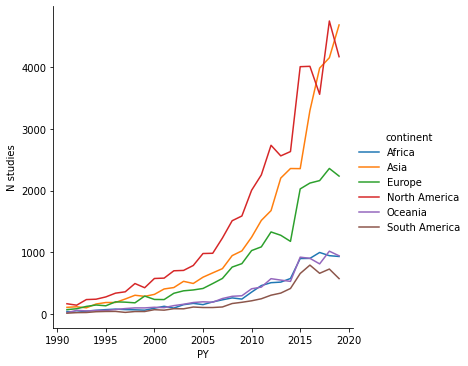

In [13]:
import seaborn as sns
sns.relplot("PY","N studies",hue="continent",data=pdf,kind="line")
plt.savefig('../plots/literature_distribution/PY_continent_n.pdf')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


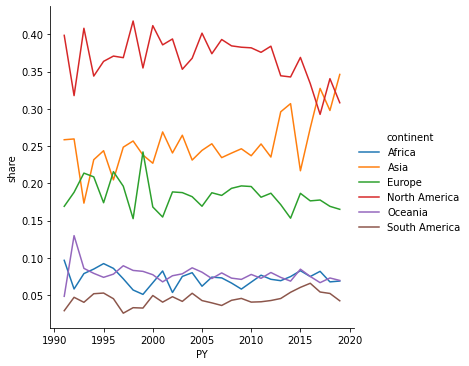

In [14]:
pdf['share'] = pdf['N studies'] / pdf.groupby('PY')['N studies'].transform('sum')

sns.relplot("PY","share",hue="continent",data=pdf,kind="line")
plt.savefig('../plots/literature_distribution/PY_continent_shares.pdf')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


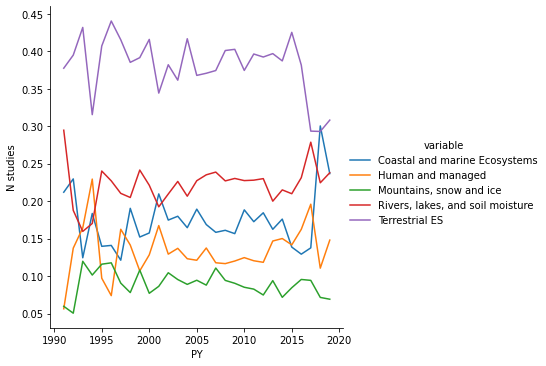

In [15]:


pdf = (df_places[['id','PY']+pred_cats]
       .melt(id_vars=["id","PY"])
       .query('value>0.5')
       .groupby(['PY','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       #.query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )

pdf['N studies'] = pdf['N studies'] / pdf.groupby("PY")['N studies'].transform('sum')
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="variable",data=pdf,kind="line")
plt.savefig("../plots/literature_distribution/PY_continent_attrib.pdf")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


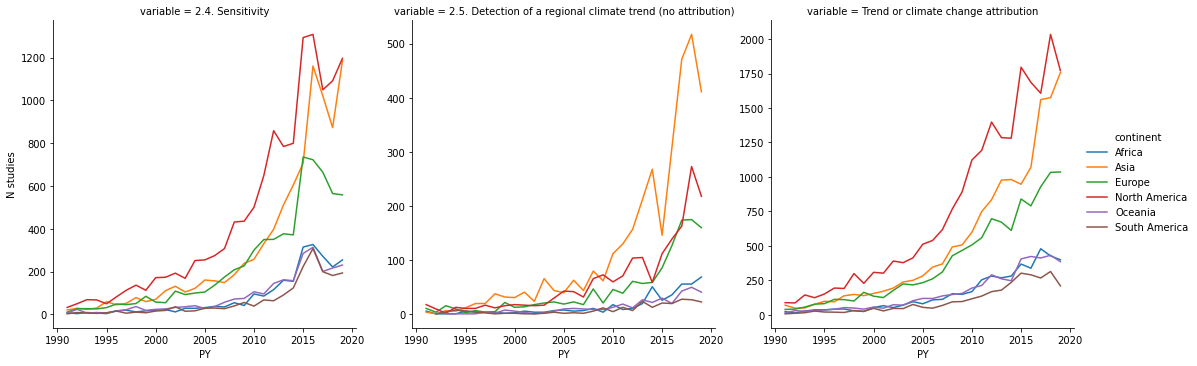

In [16]:
pdf = (df_places[['id','continent','PY']+attrib_cats]
       .melt(id_vars=["id","continent","PY"])
       .query('value>0.5')
       .groupby(['PY','continent','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="continent",data=pdf,col="variable",kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_attrib.pdf")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


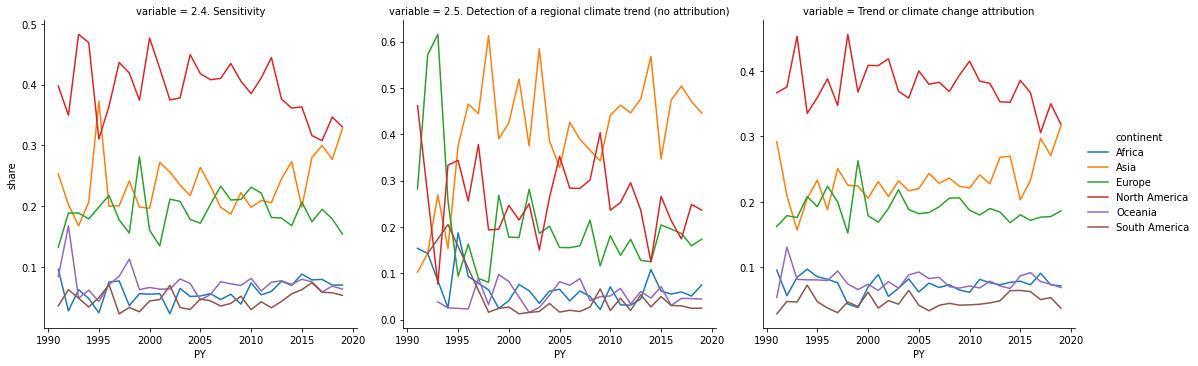

In [17]:
pdf['share'] = pdf['N studies'] / pdf.groupby(['PY','variable'])['N studies'].transform('sum')
sns.relplot("PY","share",hue="continent",data=pdf,col="variable",kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_attrib_share.pdf")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


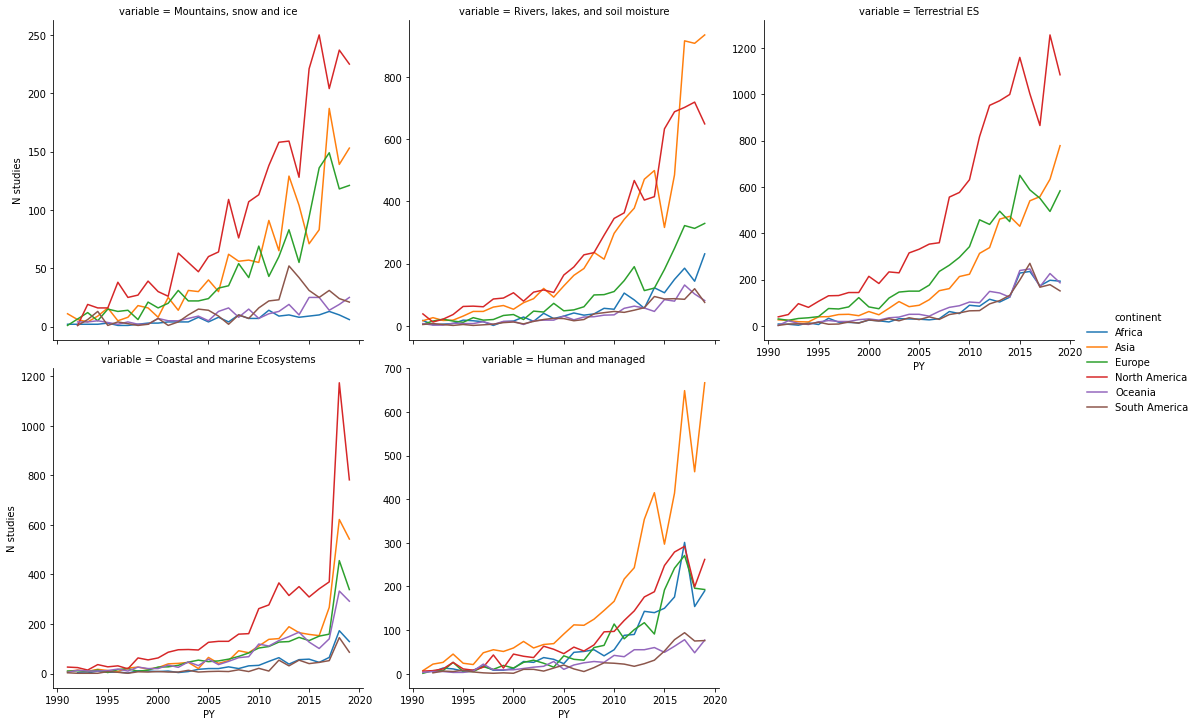

In [18]:
pdf = (df_places[['id','continent','PY']+pred_cats]
       .melt(id_vars=["id","continent","PY"])
       .query('value>0.5')
       .groupby(['PY','continent','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="continent",data=pdf,col="variable", col_wrap=3,kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_impact.pdf")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


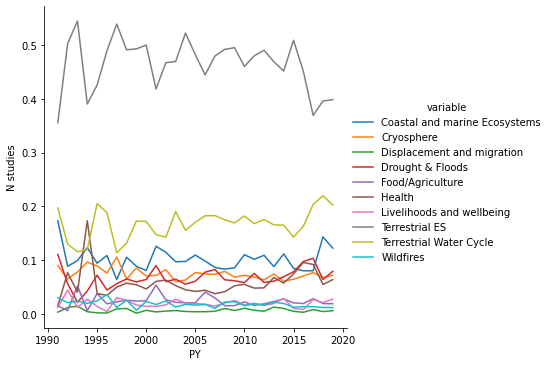

In [23]:


pdf = (df_places[['id','PY']+specific_impacts]
       .melt(id_vars=["id","PY"])
       .query('value>0.5')
       .groupby(['PY','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       #.query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )

pdf['N studies'] = pdf['N studies'] / pdf.groupby("PY")['N studies'].transform('sum')
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="variable",data=pdf,kind="line")
plt.savefig("../plots/literature_distribution/PY_continent_impacts.pdf")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


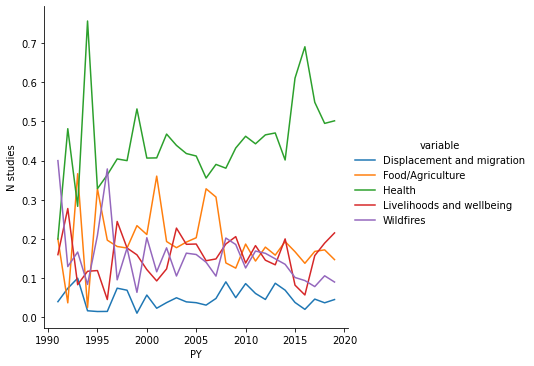

In [24]:
human_impacts = [
#     '18 - Terrestrial Water Cycle - mean_prediction',
#     '18 - Drought & Floods - mean_prediction',
#     '18 - Cryosphere - mean_prediction',
#     '18 - Coastal and marine Ecosystems - mean_prediction',
#     '18 - Terrestrial ES - mean_prediction',
#     #'18 - Carbon Cycle - mean_prediction',
    '18 - Wildfires - mean_prediction',
    '18 - Food/Agriculture - mean_prediction',
    '18 - Livelihoods and wellbeing - mean_prediction',
    '18 - Health - mean_prediction',
    '18 - Displacement and migration - mean_prediction',
    #'18 - Other anthropogenic - mean_prediction'
]

pdf = (df_places[['id','PY']+human_impacts]
       .melt(id_vars=["id","PY"])
       .query('value>0.5')
       .groupby(['PY','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       #.query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )

pdf['N studies'] = pdf['N studies'] / pdf.groupby("PY")['N studies'].transform('sum')
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="variable",data=pdf,kind="line")
plt.savefig("../plots/literature_distribution/PY_continent_impacts.pdf")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

[Text(0.5, 0, 'Terrestrial ES'),
 Text(1.5, 0, 'Coastal and marine Ecosystems'),
 Text(2.5, 0, 'Mountains, snow and ice'),
 Text(3.5, 0, 'Rivers, lakes, and soil moisture'),
 Text(4.5, 0, 'Human and managed')]

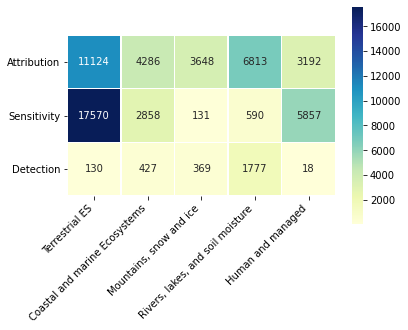

In [19]:
m = np.zeros((len(attrib_cats),len(pred_cats)),int)

for i, ac in enumerate(attrib_cats):
    for j, pc in enumerate(pred_cats):
        df_comb = df.loc[(df[ac]>0.5) & (df[pc]>0.5),]
        df_comb['comb'] = df_comb[ac] + df_comb[pc]         
            
        m[i,j]=df_comb.shape[0]
        
attrib_labels = ["Attribution","Sensitivity","Detection"]
fig, ax = plt.subplots()
sns.heatmap(m,cmap="YlGnBu",ax=ax, linewidths=.5,square=True,annot=True,fmt="d")
ax.set_yticklabels(attrib_labels,rotation=0)
ax.set_xticklabels([x.split(" - ")[1] for x in pred_cats],rotation=45,ha="right")

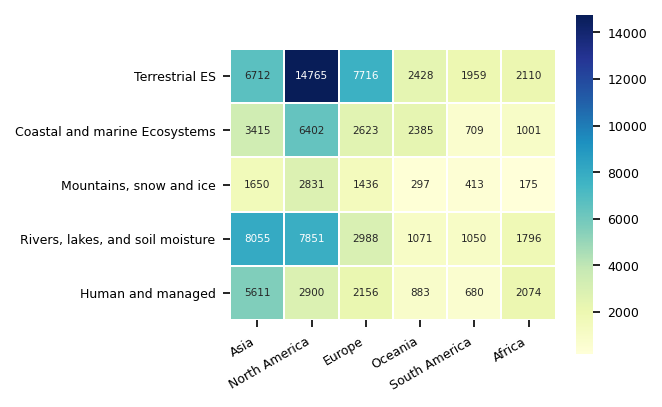

In [20]:
continents = [x for x in df_places.continent.unique() if x is not None]

m = np.zeros((len(pred_cats),len(continents)),int)

for i, cc in enumerate(continents):
    for j, pc in enumerate(pred_cats):
        df_comb = df_places.loc[(df_places["continent"]==cc) & (df_places[pc]>0.5),]          
        m[j,i]=df_comb.shape[0]
        

fig, ax = plt.subplots(figsize=(3.5,3),dpi=150)
sns.heatmap(
    m,cmap="YlGnBu",ax=ax, linewidths=.5,square=True,annot=True,fmt="d", 
    annot_kws={"size":5}
)
ax.set_xticklabels(continents,rotation=30, fontsize=6, ha="right")
ax.set_yticklabels([x.split(" - ")[1] for x in pred_cats],rotation=0,ha="right", fontsize=6)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)


[Text(0, 0.5, 'Terrestrial ES'),
 Text(0, 1.5, 'Coastal and marine Ecosystems'),
 Text(0, 2.5, 'Mountains, snow and ice'),
 Text(0, 3.5, 'Rivers, lakes, and soil moisture'),
 Text(0, 4.5, 'Human and managed')]

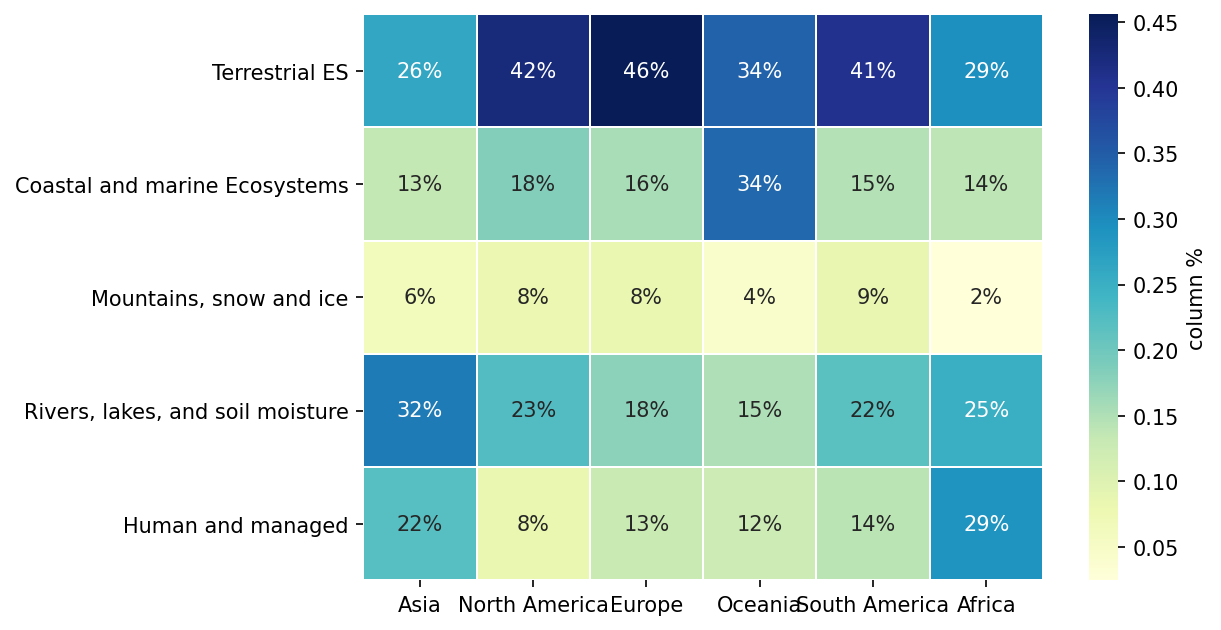

In [21]:
fig, ax = plt.subplots(figsize=(8,5),dpi=150)
sns.heatmap(
    m/m.sum(axis=0),
    cmap="YlGnBu",ax=ax, 
    linewidths=.5,square=True,
    annot=True,fmt=".0%",
    cbar_kws={"label": "column %"}
)
ax.set_xticklabels(continents,rotation=0)
ax.set_yticklabels([x.split(" - ")[1] for x in pred_cats],rotation=0,ha="right")


[Text(0, 0.5, 'Terrestrial ES'),
 Text(0, 1.5, 'Coastal and marine Ecosystems'),
 Text(0, 2.5, 'Mountains, snow and ice'),
 Text(0, 3.5, 'Rivers, lakes, and soil moisture'),
 Text(0, 4.5, 'Human and managed')]

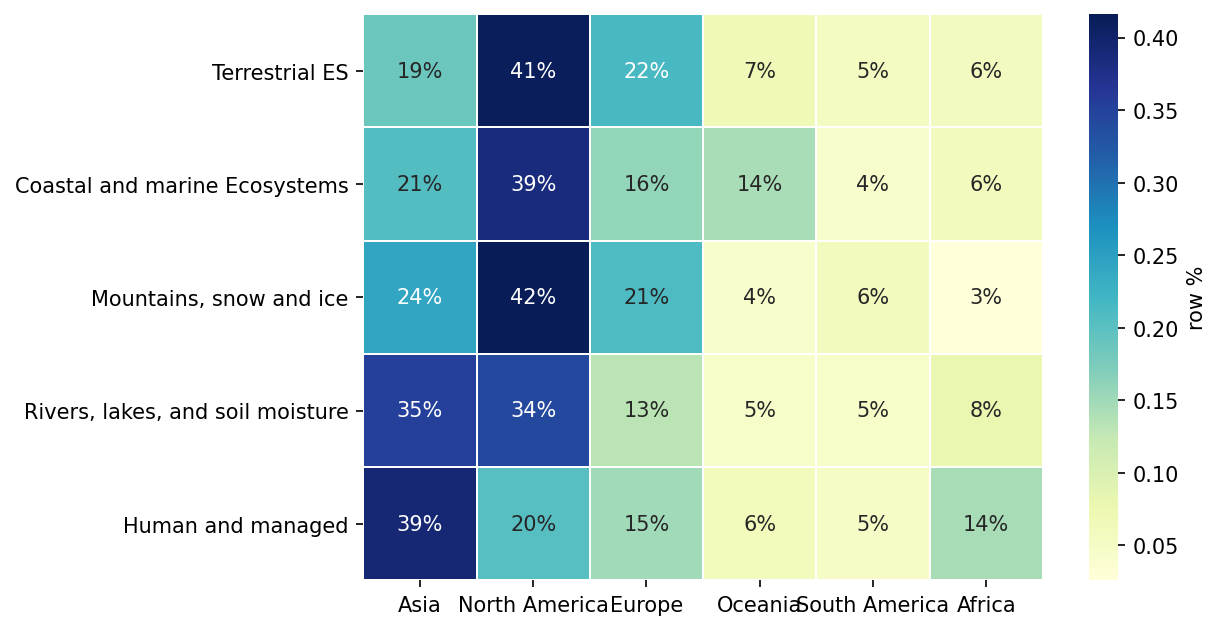

In [22]:
fig, ax = plt.subplots(figsize=(8,5),dpi=150)
sns.heatmap(
    m/m.sum(axis=1,keepdims=True),
    cmap="YlGnBu",ax=ax, 
    linewidths=.5,square=True,
    annot=True,fmt=".0%",
    cbar_kws={"label": "row %"}
)
ax.set_xticklabels(continents,rotation=0)
ax.set_yticklabels([x.split(" - ")[1] for x in pred_cats],rotation=0,ha="right")
